## Part 2: Model Training

In this section, three algorithms — Logistic Regression, KNN, and Artificial Neural Network (ANN) — were applied to the training and validation data.  
First, the data was preprocessed and encoded, then each model was tuned and evaluated to achieve the best possible performance.

In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)


plt.rcParams["figure.figsize"] = (6,4)
sns.set(style="whitegrid")

In [ ]:
def load_split(name):
    base_dir = "./notebook"
    csv_path = os.path.join(base_dir, f"{name}.csv")
    pkl_path = os.path.join(base_dir, f"{name}.pkl")
    if os.path.exists(csv_path):
        return pd.read_csv(csv_path)
    elif os.path.exists(pkl_path):
        import joblib
        return joblib.load(pkl_path)
    else:
        raise FileNotFoundError(f"Neither {csv_path} nor {pkl_path} found.")

In [30]:
X_train = load_split("X_train")
X_val   = load_split("X_val")
X_test  = load_split("X_test")

y_train = load_split("y_train")
y_val   = load_split("y_val")
y_test  = load_split("y_test")


if isinstance(y_train, pd.DataFrame): y_train = y_train.squeeze().values
if isinstance(y_val, pd.DataFrame):   y_val   = y_val.squeeze().values
if isinstance(y_test, pd.DataFrame):  y_test  = y_test.squeeze().values

print("Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)

Train: (399, 11) | Val: (122, 11) | Test: (93, 11)


In [31]:
y_train_num = y_train.replace({'Y':1, 'N':0}).astype(np.float32)
y_val_num   = y_val.replace({'Y':1, 'N':0}).astype(np.float32)
y_test_num  = y_test.replace({'Y':1, 'N':0}).astype(np.float32)

C:\Users\mbahr\AppData\Local\Temp\ipykernel_10452\61229475.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train_num = y_train.replace({'Y':1, 'N':0}).astype(np.float32)
C:\Users\mbahr\AppData\Local\Temp\ipykernel_10452\61229475.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val_num   = y_val.replace({'Y':1, 'N':0}).astype(np.float32)
C:\Users\mbahr\AppData\Local\Temp\ipykernel_10452\61229475.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old

In [33]:
from sklearn.preprocessing import OneHotEncoder

cat_cols = X_train.select_dtypes(include='object').columns.tolist()


encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')


X_train_encoded = encoder.fit_transform(X_train[cat_cols])
X_val_encoded   = encoder.transform(X_val[cat_cols])
X_test_encoded  = encoder.transform(X_test[cat_cols])


num_cols_train = X_train.drop(columns=cat_cols).values
X_train_final = np.hstack([num_cols_train, X_train_encoded])

num_cols_val = X_val.drop(columns=cat_cols).values
X_val_final = np.hstack([num_cols_val, X_val_encoded])

num_cols_test = X_test.drop(columns=cat_cols).values
X_test_final = np.hstack([num_cols_test, X_test_encoded])

print("Encoding done. Shapes:")
print("X_train_final:", X_train_final.shape)
print("X_val_final:", X_val_final.shape)
print("X_test_final:", X_test_final.shape)

Encoding done. Shapes:
X_train_final: (399, 14)
X_val_final: (122, 14)
X_test_final: (93, 14)


In [34]:

log_reg = LogisticRegression(max_iter=1000, random_state=42)


log_reg.fit(X_train_final, y_train)


y_val_pred = log_reg.predict(X_val_final)


print("Logistic Regression - Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Logistic Regression - Validation Accuracy: 0.819672131147541

Classification Report:
               precision    recall  f1-score   support

           N       0.86      0.50      0.63        38
           Y       0.81      0.96      0.88        84

    accuracy                           0.82       122
   macro avg       0.84      0.73      0.76       122
weighted avg       0.83      0.82      0.80       122



In [52]:

best_k = None
best_acc = 0
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_final, y_train_num)
    acc = accuracy_score(y_val_num, knn.predict(X_val_final))
    if acc > best_acc:
        best_acc = acc
        best_k = k

print(f"Best K: {best_k} with Accuracy: {best_acc:.4f}")


knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_final, y_train_num)
y_val_pred_knn = knn_best.predict(X_val_final)



Best K: 17 with Accuracy: 0.8279


In [53]:
X_train_final = X_train_final.astype(np.float32)
X_val_final   = X_val_final.astype(np.float32)
X_test_final  = X_test_final.astype(np.float32)

In [54]:
import tensorflow as tf
from tensorflow.keras import models, layers



X_train_ann = X_train_final.astype(np.float32)
X_val_ann   = X_val_final.astype(np.float32)


ann = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_ann.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = ann.fit(
    X_train_ann, y_train_num,
    epochs=50,
    validation_data=(X_val_ann, y_val_num),
    verbose=0
)


val_loss, val_acc = ann.evaluate(X_val_ann, y_val_num, verbose=0)
print("ANN - Validation Accuracy:", val_acc)

e:\Mohammad Bahrami_Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ANN - Validation Accuracy: 0.7786885499954224


In [55]:
if 'y_val_num' not in globals():
    y_val_num = pd.Series(y_val).replace({'Y':1,'N':0}).astype(np.float32).values

if 'y_train_num' not in globals():
    y_train_num = pd.Series(y_train).replace({'Y':1,'N':0}).astype(np.float32).values


if 'y_val_pred_log' not in globals():
    y_val_pred_log = log_reg.predict(X_val_final)


if 'knn_best' not in globals():
    if 'best_k' not in globals():
        best_k, _best_acc = None, -1
        for k in range(1, 21):
            _knn = KNeighborsClassifier(n_neighbors=k).fit(X_train_final, y_train_num)
            _acc = accuracy_score(y_val_num, _knn.predict(X_val_final))
            if _acc > _best_acc:
                best_k, _best_acc = k, _acc
    knn_best = KNeighborsClassifier(n_neighbors=best_k).fit(X_train_final, y_train_num)


if 'y_val_pred_knn' not in globals():
    y_val_pred_knn = knn_best.predict(X_val_final)


if 'val_acc' not in globals():
    y_val_pred_ann = (ann.predict(X_val_final).ravel() > 0.5).astype(int)
    val_acc = accuracy_score(y_val_num, y_val_pred_ann)


In [56]:
if 'y_val_pred_log' in globals():
    y_val_pred_log = pd.Series(y_val_pred_log).replace({'Y':1,'N':0}).astype(int).values


if 'y_val_pred_knn' in globals():
    y_val_pred_knn = pd.Series(y_val_pred_knn).replace({'Y':1,'N':0}).astype(int).values


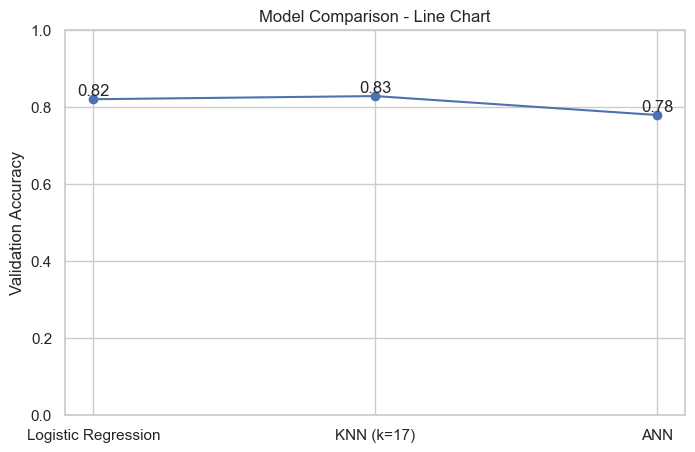

In [57]:
model_names = ["Logistic Regression", f"KNN (k={best_k})", "ANN"]
val_accuracies = [
    accuracy_score(y_val_num, y_val_pred_log),
    accuracy_score(y_val_num, y_val_pred_knn),
    val_acc
]

plt.figure(figsize=(8,5))
plt.plot(model_names, val_accuracies, marker='o', linestyle='-')
plt.ylabel("Validation Accuracy")
plt.title("Model Comparison - Line Chart")
plt.ylim(0, 1)

for i, acc in enumerate(val_accuracies):
    plt.text(i, acc+0.01, f"{acc:.2f}", ha='center')

plt.show()

In [58]:
import joblib

joblib.dump(log_reg, "logistic_regression_model.pkl")
joblib.dump(knn, "knn_model.pkl")
joblib.dump(ann, "ann_model.pkl")


import pickle

with open("data_splits.pkl", "wb") as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)

print("Models and data have been saved")

Models and data have been saved


## Conclusion of Part 2

The evaluation results on the validation data showed that:  
- The KNN model (with k=17) achieved the best performance (Accuracy ≈ 0.83).  
- Logistic Regression performed reasonably well with Accuracy ≈ 0.82.  
- Artificial Neural Network (ANN) performed slightly worse (Accuracy ≈ 0.78).  

Therefore, for this dataset, KNN is the best choice for further work.